In [1]:
#Imports - general
import random
random.seed(15)
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')
from math import ceil, sqrt
#import sklearn
from sklearn.metrics import f1_score, roc_curve, auc, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
%matplotlib inline

#Imports - RDKit
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem.rdMolDescriptors import *

#Imports - additional
from os import listdir #for getting a list of files in a dir to process checkpoints
import time # for real-time timing the progress of the network

path = 'data/targets/'   #path to .ism files
batch_number = 0
#Get the list of filenames in data/targets/
#ordered by the size of class, descending:
with open("receptors_desc.txt", "r") as f:
    receptors = [l.strip().split() for l in f.readlines()]
#receptors[:5]

#---

# Functions

## Preparing the dataset

def read_ism(file_name):
    ''' Parse an .ism file, returning a list of smiles of molecules '''
    mol_list = []
    with open(file_name, 'r') as f:
        frl = f.readlines()
    for line in frl:
        line = line.split('\t')
        smile = line[0]
        mol_list.append(smile)
    return mol_list

#### Creating molecule representations

def get_class_vectors(mol_matrix, rType = 'fingerprint', f_size=2048):
    ''' For each molecule in the array (list of lists):
        create its vector representation for training (fingerprint/descriptor/mixed)
        and a binary vector showing which classes it belongs to.
        f_size - length of the fingerprint
    '''
    cv_dict = {}
    for i,l in enumerate(mol_matrix):
        for smile in l:
            if smile not in cv_dict:
                
                mol = MolFromSmiles(smile)
                if rType == 'fingerprint':
                    rep = fingerprint(mol, f_size)
                elif rType == 'descriptor':
                    rep = descriptor(mol)
                else: # both representations
                    rep = descriptor(mol) + list(fingerprint(mol,f_size))
                
                labels = [0]*len(mol_matrix)
                cv_dict[smile] = [rep, labels]
            cv_dict[smile][1][i] = 1
    # Normalize descriptors
    if rType != 'fingerprint':
        matrix_to_norm = []
        for vals in cv_dict.values():
            matrix_to_norm.append(vals[0][:37])
        matrix_to_norm = np.array(matrix_to_norm)
        v_min = matrix_to_norm.min(axis=0)
        v_max = matrix_to_norm.max(axis=0) - v_min
        
        for key in cv_dict.keys():
            for i in range(37):
                normed_val = (cv_dict[key][0][i] - v_min[i]) / v_max[i]
                cv_dict[key][0][i] = normed_val
        
    return cv_dict

def fingerprint(mol, f_size=2048):
    return GetMorganFingerprintAsBitVect(mol,2,f_size)

def descriptor(mol):
    functions = [CalcChi0n,
            CalcChi0v,
            CalcChi1n,
            CalcChi1v,
            CalcChi2n,
            CalcChi2v,
            CalcChi3n,
            CalcChi3v,
            CalcChi4n,
            CalcChi4v,
            CalcExactMolWt,
            CalcFractionCSP3,
            CalcHallKierAlpha,
            CalcKappa1,
            CalcKappa2,
            CalcKappa3,
            CalcLabuteASA,
            CalcNumAliphaticCarbocycles,
            CalcNumAliphaticHeterocycles,
            CalcNumAliphaticRings,
            CalcNumAmideBonds,
            CalcNumAromaticCarbocycles,
            CalcNumAromaticHeterocycles,
            CalcNumAromaticRings,
            CalcNumBridgeheadAtoms,
            CalcNumHBA,
            CalcNumHBD,
            CalcNumHeteroatoms,
            CalcNumHeterocycles,
            CalcNumLipinskiHBA,
            CalcNumLipinskiHBD,
            CalcNumRings,
            CalcNumSaturatedCarbocycles,
            CalcNumSaturatedHeterocycles,
            CalcNumSaturatedRings,
            CalcNumSpiroAtoms,
            CalcTPSA]
        
    descriptors = []
    for function in functions:
        descriptors.append(function(mol))
    return descriptors

def prepare_sets(mol_matrix, val_prc=0.25, rType='fingerprint', f_size=2048):
    ''' Create training and validation sets with labels from an array of smiles
        rType - type of representation - fingerprint/descriptor/mixed
        f_size - size of the fingerprint if rType is fingerprint or mixed '''
    # Create a representation and a class vector for each molecule
    molecules = get_class_vectors(mol_matrix,rType,f_size)

    # Split the data into training and validation sets
    mts=[[],[]]
    for val in molecules.values():
        mts[0].append(val[0]) # [fingerprint]
        mts[1].append(val[1]) # [label]

    molecules_split = train_test_split(mts[0], mts[1], test_size=val_prc, random_state=15)

    # Validation set:
    #     a list of representations (mols) and
    #     a list of corresponding class vectors (labels)
    val_mols = np.array(molecules_split[1])
    val_labels = np.array(molecules_split[3])
    # Training set:
    train_set = [[],[]]
    train_set[0] = np.array(molecules_split[0])
    train_set[1] = np.array(molecules_split[2])
    
    return train_set, val_mols, val_labels

## Neuron layers

def neuron_layer(isize, hsize, prev_layer):
    ''' Create a single neuron layer - weight, bias, placeholder '''
    # weights and biases
    w = tf.Variable(tf.random_normal((isize, hsize), stddev=1/sqrt(isize)))
    b = tf.Variable(tf.random_normal((hsize,), stddev=0.1))
    # neuron
    h = tf.nn.relu(tf.matmul(prev_layer, w) + b)
    return w,b,h

def setup_layers(layers, osize, isize=2048):
    ''' Create placeholders, weights and biases for all requested layers '''
    x = tf.placeholder(tf.float32, shape=[None,isize])
    active_layers = {'x':x,'w':[],'b':[],'h':[]}
    
    for i in range(len(layers)):
        if i == 0:
            w,b,h = neuron_layer(isize, layers[i], x)
        else:
            w,b,h = neuron_layer(layers[i-1], layers[i], prev_h)
        active_layers['w'].append(w)
        active_layers['b'].append(b)
        active_layers['h'].append(h)
        prev_h = h
    
    # Output Layer
    wo = tf.Variable(tf.random_normal((layers[-1], osize), stddev=1/sqrt(layers[-1])))
    bo = tf.Variable(tf.random_normal((osize,), stddev=0.1))
    a = tf.matmul(h, wo) + bo #h is the one last initialized in the loop > of the last layer
    
    # Placeholder for targets
    t = tf.placeholder(tf.float32, shape=[None, osize])
    
    active_layers['out'] = [wo,bo,a,t]
    return active_layers

## Training functions

def next_batch(data, size): #data = [[fingerprints], [labels]]
    ''' Extract the next batch from a dataset.
        If dataset size is not dividable by batch size with reminder 0,
       the last full batch and the remaining incomplete batch will be merged 
       to incorporate all data.'''
    global batch_number
    if batch_number == len(data[0])//size-1:
        #the last batch may be larger to incorporate all data
        # -1 because the first batch number is 0
        start = batch_number*size
        batch_number = 0
        return data[0][start:], data[1][start:]
    start = batch_number*size
    batch_number += 1
    return data[0][start:start+size], data[1][start:start+size]

def shuffle_data(data):
    '''Used to shuffle the training set after an epoch'''
    indices = list(range(len(data[0])))
    random.shuffle(indices)
    new_data = [data[0][indices], data[1][indices]]
    return new_data

def timer(start,end):
    ''' For timing the training of the network '''
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds))

def tf_fractions(a1, a2):
    ''' Calculate true/false positives/negatives in a2 based on a1
        for each class seperately. '''
    num_class = len(a1[0]) #number of classes
    tp = np.array([0] * num_class)
    fn = np.array([0] * num_class)
    tn = np.array([0] * num_class)
    fp = np.array([0] * num_class)
    for i in range(num_class):
        for j in range(len(a1)):
            if a2[j][i] == a1[j][i]:
                if a1[j][i] == 1:
                    tp[i] += 1
                else:
                    tn[i] += 1
            else:
                if a1[j][i] == 1:
                    fn[i] += 1
                else:
                    fp[i] += 1
    return [tp,fn,tn,fp]

def train_network(data, batch_size, epochs, verbose=True, save=True):
    ''' This function trains the network, returning the rate of training and validation accuracy '''
    # Variables:
    global start, train, val_pred, batch_number
    iterations = len(data[0]) // batch_size * epochs
    if verbose: print(iterations, ' iterations')
    tr_rate = []
    val_rate = []
    f1 = [[],[],[]]
    tf_frac = []
    batch_number = 0
    save_step=0
    # Training:
    with tf.Session() as session:
        session.run(tf.initialize_all_variables())

        if save:
            saver.save(session, "tmp/checkpoint", global_step=save_step)
        
        # Train the network
        for i in range(iterations):
            if i != 0 and batch_number == 0:
                data = shuffle_data(data)
            
            mols, labels = next_batch(data, batch_size)
            
            session.run(train, feed_dict={x: mols, t: labels})
            
            # Display progress and make a checkpoint
            if i == 0 or (i+1)%(iterations//10) == 0:
                if save:
                    save_step += 1
                    saver.save(session, "tmp/checkpoint", global_step = save_step)
                if verbose:
                    progress = int((i+1)/(iterations//10))*10
                    now = timer(start,time.time())
                    print("%3i" % progress + '%, ' + str(now))                
            
            # Validate predictions
            if i % 200 == 0 or i == iterations-1:
                
                tr_target = labels
                tr_predictions = session.run(predict, feed_dict={x: mols, t: labels})
                tr_rate.append((tr_target == tr_predictions).all(axis=1).mean())

                val_predictions = session.run(predict, feed_dict={x: val_mols, t: val_labels})
                val_rate.append((val_labels == val_predictions).all(axis=1).mean())
                
                
                f1[0].append(f1_score(val_labels, val_predictions, average='micro'))
                f1[1].append(f1_score(val_labels, val_predictions, average='macro'))
                f1[2].append(f1_score(val_labels, val_predictions, average='weighted'))
                
        tf_frac = tf_fractions(val_labels,val_predictions)
        # Final checkpoint
        if save:
            saver.save(session, "tmp/checkpoint", global_step=save_step+1)
    return tr_rate, val_rate, f1, tf_frac

def filename_gen(plot_type='', path=''):
    ''' Generate filename for a plot. '''
    if plot_type != '':
        plot_type += '_'
    filename = plot_type
    layers_str = "{}'{}".format(len(layers),max(layers))
    filename += "{}_{}_{}_{:>6}_{}_{}_{:.4}_{}".format(
                num_class, f_size, layers_str, learning_rate, batch_size, epochs, max(val_rate), rType)
    filename = filename.replace(".","'")
    filename = filename.replace(" ","_")
    filename = path + filename + ".pdf"
    return filename

def save_accuracy_plot(tr_rate, save=True, path="plots/"):
    ''' Draws and saves a plot which displays changes of accuracy 
        during training for training and validation sets. '''
    plt.close()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    x = [i*200 for i in range(len(tr_rate))]
    ax.plot(x,tr_rate, label='trening')
    ax.plot(x,val_rate, label='walidacja')
    ax.legend(loc=5)
    ax.set_ylabel('Dokładność')
    ax.set_xlabel('Krok')
    plt.ylim([0,1])
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    
    title = "Cele terapeutyczne: {:2}, Szybkość uczenia: {}\nWarstwy: {}, Rozmiar batcha: {}, Liczba epok: {}".format(
        num_class, learning_rate, layers, batch_size, epochs)
    plt.title(title);
    
    if save:
        filename = filename_gen('',path)
        plt.savefig(filename);

def save_f1_plot(f1, save=True, path="plots/"):
    ''' Draws and saves a plot which displays changes of F1-score
        during training for the validation set.
        F1 calculated and drawn in three types of averaging. '''
    plt.close()
    fig = plt.figure()
    x = [i*200 for i in range(len(f1[0]))]
    ax = fig.add_subplot(111)
    
    ax.plot(x,f1[0], label='F1 micro')
    ax.plot(x,f1[1], label='F1 macro')
    ax.plot(x,f1[2], label='F1 ważone')
    ax.legend(loc=7)
    ax.set_ylabel('F1')
    ax.set_xlabel('Krok')
    plt.ylim([0,1])
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    
    title = "Cele terapeutyczne: {:2}, Szybkość uczenia: {}\nWarstwy: {}, Rozmiar batcha: {}, Liczba epok: {}".format(
        num_class, learning_rate, layers, batch_size, epochs)
    plt.title(title);
    
    if save:
        filename = filename_gen('f1',path)
        plt.savefig(filename);

def save_tf_fractions_plot(tff, save=True, path='plots/'):
    ''' Draws and saves a histogram of true/false positive/negative fractions:
        True Positive rate, False Positive Rate, False Negative Rate and
        False Discovery Rate.
        True Negative Rate not included due to having values indistinguishably
        close to 100%; however, TNR = 100% - FPR, and the FPR histogram is more
        visually clear. '''
    plt.close()
    fig = plt.figure()
    subplots = [fig.add_subplot(221), fig.add_subplot(222),
                fig.add_subplot(223), fig.add_subplot(224)]
    titles = ['Odsetek prawdziwie pozytywnych', 'Odsetek fałszywie pozytywnych',
              'Odsetek fałszywie negatywnych', 'Odsetek fałszywych odkryć']
    rate_values = [tff[0]/(tff[0]+tff[1]), tff[3]/(tff[2]+tff[3]),
                   tff[1]/(tff[0]+tff[1]), tff[3]/(tff[0]+tff[3])]
    xlabel = 'Cele terapeutyczne'
    xrange = range(1,len(tff[0])+1)
    
    for i, ax in enumerate(subplots):
        ax.bar(xrange, rate_values[i])
        ax.set_title(titles[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_xlim([0,num_class+2])
        vals = ax.get_yticks()
        if i == 1: #false positive rate is very small
            ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
        else:
            ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    
    plt.tight_layout()
    title = "Cele terapeutyczne: {:2}, Szybkość uczenia: {}\nWarstwy: {}, Rozmiar batcha: {}, Liczba epok: {}".format(
        num_class, learning_rate, layers, batch_size, epochs)
    fig.suptitle(title)
    fig.subplots_adjust(top=0.85)
    
    if save:
        filename = filename_gen('tff',path)
        plt.savefig(filename)
        
import pickle

def load_var(name):
    with open(name,'rb') as f:
        return pickle.load(f)

def save_var(name,var):
    with open(name,'wb') as f:
        pickle.dump(var,f)

# Uwagi

---

In [33]:
counts = {}
i = 0
for l in drug_labels:
    if sum(l) not in counts:
        counts[sum(l)] = 0
    counts[sum(l)] += 1
counts

{1: 69, 2: 58, 3: 19, 4: 13, 5: 4, 6: 4, 7: 1, 8: 5, 9: 2, 10: 1, 11: 3, 14: 1}

In [48]:
num_class = 73
rType = 'fingerprint'
f_size = 4096
layers = [800,800]
learning_rate = 0.001
lr_rate = learning_rate
batch_size = 50
epochs = 10

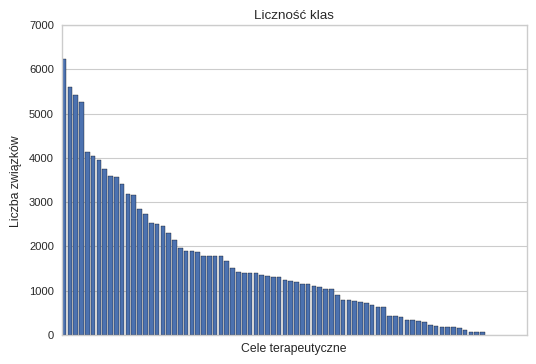

In [42]:
#''' Wykres liczności klas '''
plt.close()
#plt.bar(range(73),[int(x[1]) for x in receptors])

fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.bar(range(73),[int(x[1]) for x in receptors])
ax1.set_title('Liczność klas')
ax1.set_ylabel('Liczba związków')
ax1.set_xlabel('Cele terapeutyczne')
ax1.set_xticks([]);

---

In [2]:
with open('data/drug_targets_untrained.csv') as f: #or data/drug_targets.csv
    drug_targets = [l.strip().split(',') for l in f.readlines()[1:]]
class_to_smiles = {}
for l in drug_targets:
    if l[2] not in class_to_smiles.keys():
        class_to_smiles[l[2]] = []
    class_to_smiles[l[2]].append(l[4])

targets = [l[0].strip('.ism') for l in receptors]

drug_mol_matrix = [[]]*73
for k, v in class_to_smiles.items():
    drug_mol_matrix[targets.index(k)] = v

cv_dict = get_class_vectors(drug_mol_matrix, f_size=4096)
drug_mols, drug_labels = [], []
for v in cv_dict.values():
    drug_mols.append(v[0])
    drug_labels.append(v[1])
drug_mols, drug_labels = np.array(drug_mols), np.array(drug_labels)

In [3]:
tf.reset_default_graph()
tf.set_random_seed(15)
random.seed(15)
# Automatic network variables
isize = 4096
osize = 73
active_layers = setup_layers([800,800], osize, isize)
x = active_layers['x'] # first placeholder
a = active_layers['out'][2] # output layer activations
t = active_layers['out'][3] # placeholder for targets
saver = tf.train.Saver(max_to_keep=12)
# Objective
'''Adam Optimizer'''
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(a, t))
train = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)
# Prediction
y = tf.nn.sigmoid(a)
predict = tf.round(y)

f1=[[],[],[]]
with tf.Session() as sess:
    saver.restore(sess, 'checkpoint-12')
    #sess.run(tf.initialize_all_variables())
    
    drug_pred = sess.run(predict, feed_dict={x: drug_mols, t: drug_labels})
    drug_pred_roc = sess.run(y, feed_dict={x: drug_mols, t: drug_labels})
    drug_rate = (drug_labels == drug_pred).mean(axis=0)
    
    f1[0].append(f1_score(drug_labels, drug_pred, average='micro'))
    f1[1].append(f1_score(drug_labels, drug_pred, average='macro'))
    f1[2].append(f1_score(drug_labels, drug_pred, average='weighted'))
    tf_frac = tf_fractions(drug_labels,drug_pred)

/home/maks/anaconda3/envs/deep_learning/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/maks/anaconda3/envs/deep_learning/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [12]:
drug_rate

array([ 0.95555556,  0.95555556,  0.92222222,  0.94444444,  0.96111111,
        0.96111111,  0.97777778,  0.98888889,  0.91666667,  0.99444444,
        0.96111111,  0.91666667,  0.93333333,  0.92222222,  0.93888889,
        0.88888889,  0.91111111,  1.        ,  0.94444444,  0.93333333,
        1.        ,  0.96666667,  1.        ,  0.98888889,  0.97777778,
        0.93888889,  1.        ,  0.94444444,  0.93888889,  0.96666667,
        0.98333333,  0.96111111,  0.91666667,  0.90555556,  0.98333333,
        0.96666667,  0.97222222,  0.97222222,  0.93333333,  0.98888889,
        0.94444444,  1.        ,  0.97222222,  0.94444444,  1.        ,
        0.98333333,  0.95555556,  0.96111111,  1.        ,  0.97777778,
        1.        ,  0.97222222,  1.        ,  1.        ,  0.93888889,
        1.        ,  1.        ,  1.        ,  1.        ,  0.98888889,
        0.98888889,  0.99444444,  1.        ,  0.98333333,  1.        ,
        1.        ,  0.97222222,  0.98333333,  1.        ,  1.  

In [4]:
tff = tf_frac

sum(tf_frac[1])/460

(tff[1]+tff[3])#[np.where((tff[1]+tff[3])!=0)]

(tff[0]+tff[2])#[np.where((tff[0]+tff[2])!=0)]

norep = np.where(sum(drug_labels)==0)[0]

rate_values[0][norep]=100

rate_values[1][norep]

lol1 = [np.where(rate_values[i]==1)[0] for i in range(4)]
lol2 = [np.where(rate_values[i]==0)[0] for i in range(4)]
for i in range(4):
    print(lol1[i],lol2[i])

labels = sum(drug_labels)

lol2[1]

np.array([c for c in labels if c!=0]).mean()

print(' tpr=1',labels[lol1[0]],'\n',
      'fnr=1',labels[lol1[2]],'\n',
      'fpr=0',labels[lol2[1]],'\n',
      'fdr=1',labels[lol1[3]],'\n',
      'fdr=0',labels[lol2[3]]
     )

rate_values[3]

i=71
tff[0][i],tff[3][i],tff[1][i]

rate_values[0][np.where(np.isnan(rate_values[3])==True)]

(tff[0]+tff[3])[lol2[3]]

A = np.array([1,14,25,55,59])
B = np.array([14,59])

np.where((A==B).any())

In [23]:
norep

array([17, 20, 26, 44, 48, 50, 52, 53, 55, 56, 57, 58, 61, 62, 64, 65, 68,
       69, 70])

In [22]:
tff[3][norep] #false positive

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

/home/maks/anaconda3/envs/deep_learning/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
/home/maks/anaconda3/envs/deep_learning/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


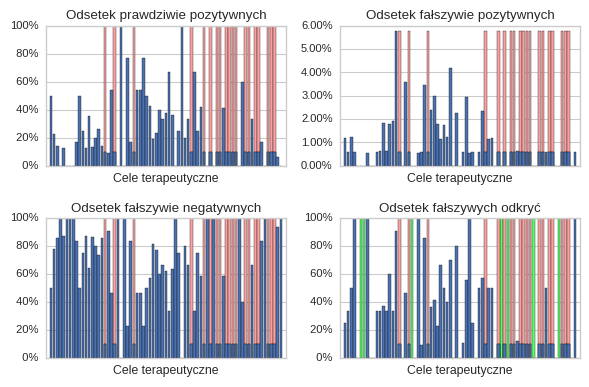

In [26]:
num_class=73
norep = np.where(sum(drug_labels)==0)[0]
plt.close()
fig = plt.figure()
subplots = [fig.add_subplot(221), fig.add_subplot(222),
            fig.add_subplot(223), fig.add_subplot(224)]
titles = ['Odsetek prawdziwie pozytywnych', 'Odsetek fałszywie pozytywnych',
          'Odsetek fałszywie negatywnych', 'Odsetek fałszywych odkryć']
rate_values = [tff[0]/(tff[0]+tff[1]), tff[3]/(tff[2]+tff[3]),
               tff[1]/(tff[0]+tff[1]), tff[3]/(tff[0]+tff[3])]

fdr_nan = np.where(np.isnan(rate_values[3])==True)[0] # where both false positives and true positives equal 0

xlabel = 'Cele terapeutyczne'
xrange = np.arange(1,len(tff[0])+1)

for i, ax in enumerate(subplots):
    ax.bar(xrange, rate_values[i]) #blue
    if i == 3:
        ax.bar(xrange[fdr_nan],[max(rate_values[i])]*fdr_nan.size,color="#59ff69") #green; tp+fp=0
    ax.bar(xrange[norep],[max(rate_values[i])]*19,color='red') #red
    ax.set_title(titles[i])
    ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_xlim([0,num_class+2])
    vals = ax.get_yticks()
    if i == 1: #false positive rate is very small
        ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
    else:
        ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

plt.tight_layout();
plt.savefig('drug_tff2.pdf')

In [75]:
print(tff[3][fdr100],(tff[0]+tff[3])[fdr100])

[1 1 1 1 1] [1 1 1 1 1]


In [ ]:
dla białek [fdr100] jest:
100 procent fdr to jedna znaleziona czasteczka i znaleziona nieprawidłowo
co nie jest dużym problemem
białko oprm1 ma tych cząsteczek 9 i nie udało się znaleźć żadnej, pozostałe mają mało więc nic dziwnego
oprm1 - co to za białko, czy należy do klasy, która jest mało reprezentowana w zbiorze treningowym

In [62]:
fdr100 = np.where(rate_values[3] == 1); fdr100

(array([ 3,  7, 23, 39, 72]),)

In [36]:
np.array(receptors)[fdr100]

array([['OPRM1.ism', '5263'],
       ['CNR1.ism', '3753'],
       ['EDNRA.ism', '1875'],
       ['CCKBR.ism', '1216'],
       ['NR1I2.ism', '59']], 
      dtype='<U11')

In [58]:
drug_labels.sum(axis=0)[fdr100]

array([9, 1, 1, 1, 4])

In [72]:
drug_labels.sum(axis=0)

array([12,  9, 14,  9,  8,  7,  4,  1, 18,  2,  8, 16, 14, 15, 10, 23,  7,
        0, 11, 13,  0,  6,  1,  1, 13,  6,  0, 13, 13, 13,  2,  7, 16, 13,
        5,  3,  8, 12, 11,  1, 12,  1,  5,  9,  0,  3,  8, 12,  0,  4,  0,
        5,  0,  0, 17,  0,  0,  0,  0,  2,  5,  0,  0,  3,  0,  0,  6,  3,
        0,  0,  0, 16,  4])

---

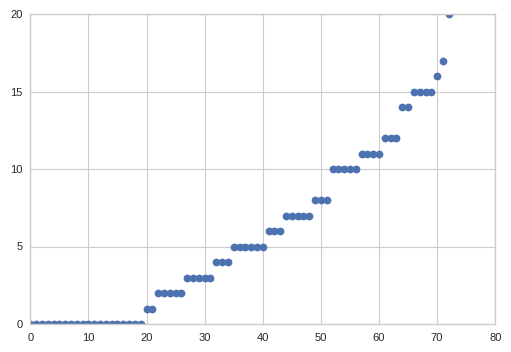

In [116]:
#plt.plot(list(range(73)),scp[0],'o')
#plt.plot(list(range(73)),scp[1],'o')
plt.plot(list(range(73)),sorted(scp[3]+scp[1]),'o');

In [84]:
sum(scp[1])/sum(scp[1]+scp[2])

0.0074132492113564673

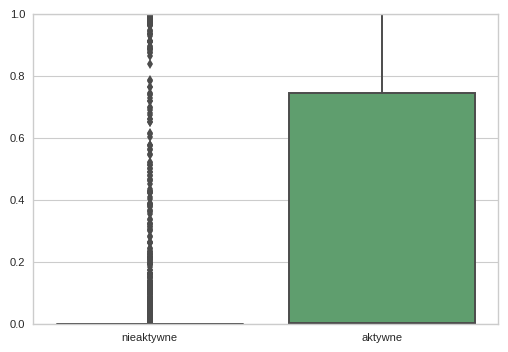

In [4]:
sns.boxplot(drug_labels.flatten(),drug_pred_roc.flatten())
plt.xticks(plt.xticks()[0],['nieaktywne', 'aktywne'])
plt.savefig('boxplot.pdf');

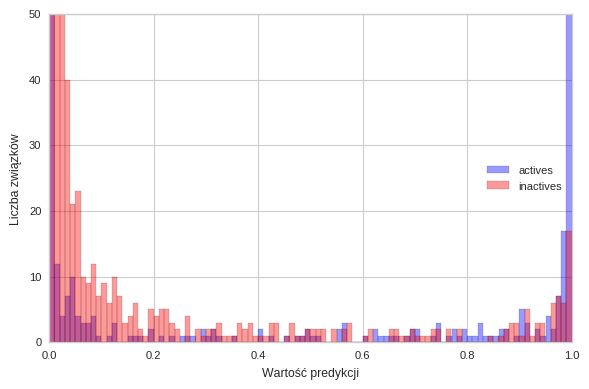

In [70]:
d = drug_labels.astype(bool)
sns.distplot(drug_pred_roc[d], kde=False, bins=100, label='actives', color='b')
sns.distplot(drug_pred_roc[~d], kde=False, bins=100, label='inactives', color='r')
plt.legend(loc='center right')
#plt.xlim([0,1]);
plt.ylim([0,50])
plt.xlabel('Wartość predykcji')
plt.ylabel('Liczba związków')
plt.tight_layout()
#plt.savefig('distplot2.pdf');

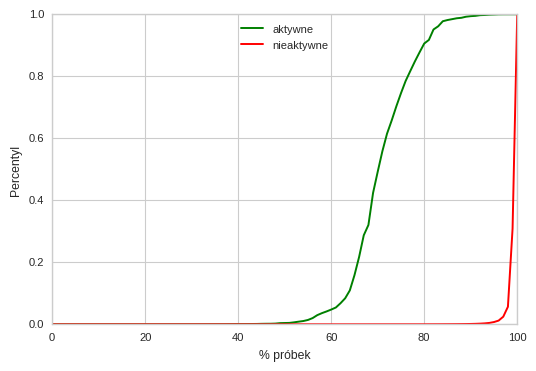

In [65]:
labels, pred = drug_labels, drug_pred_roc
q = np.arange(101)
plt.plot(q, np.percentile(pred[d], q), label='aktywne', color='g')
plt.plot(q, np.percentile(pred[~d], q), label='nieaktywne', color='r')
plt.xlabel('% próbek')
plt.ylabel('Percentyl')
plt.legend(loc='upper center');
#plt.savefig('percentyl.pdf')

In [6]:
[sum(i) for i in tf_fractions(drug_labels, (drug_pred_roc > 0.3).astype(float))]

[150, 129, 12551, 310]

In [9]:
(drug_pred_roc > 0.3).astype(float)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [117]:
precision_score(drug_pred,drug_labels, average="weighted")

/home/maks/anaconda3/envs/deep_learning/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.40009749562594416

In [122]:
precision_score((drug_pred_roc > 0.01).astype(float),drug_labels, average="weighted")

/home/maks/anaconda3/envs/deep_learning/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.50613123118207448

In [196]:
i = 0.1
tp=sum(d[np.where(pred>i)])
fp=sum(~d[np.where(pred>i)])
tpr = tp/460
fpr = fp/12680
print(tpr*100,fpr*100)
print(tp,460-tp,12680-fp,fp)

36.0869565217 1.6403785489
166 294 12472 208


In [124]:
sum((drug_pred_roc > 0.01).astype(float))

array([ 23.,  20.,  18.,   7.,  16.,  16.,   5.,   4.,  12.,   8.,  11.,
        19.,  34.,  18.,  19.,  14.,  30.,   2.,   6.,  25.,   0.,  14.,
         1.,   5.,  16.,  33.,   1.,  23.,  30.,  27.,   7.,  12.,  18.,
        28.,   5.,  14.,  12.,  22.,  25.,   4.,  21.,   4.,   5.,  21.,
         4.,   7.,   5.,  16.,   6.,  16.,   0.,   3.,   2.,   0.,  18.,
         0.,   1.,   0.,   1.,   4.,   8.,   1.,   0.,   9.,   0.,   3.,
         3.,   0.,   2.,   0.,   0.,   2.,   3.])

In [80]:
accuracy_score(drug_pred, drug_labels)

0.14444444444444443

In [75]:
fpr, tpr, thresholds = roc_curve(drug_labels.flatten(), drug_pred_roc.flatten())

In [76]:
auc(fpr,tpr)

0.82670827047044293

In [77]:
fpr[np.where(tpr==0.4)]

array([ 0.0214511,  0.0216877])

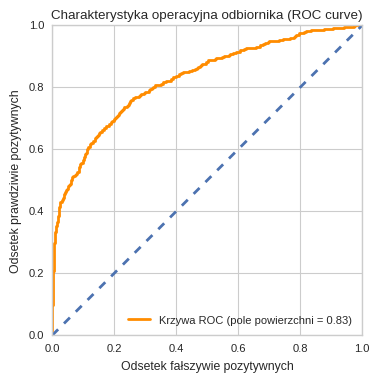

In [78]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='Krzywa ROC (pole powierzchni = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='#4C72B0', lw=2, linestyle='--')
plt.axes().set_aspect('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.title('Charakterystyka operacyjna odbiornika (ROC curve)')
plt.legend(loc="lower right")
#plt.savefig('plots/best/drugs_roc.pdf')
plt.show()

In [85]:
f1

[[0.39652677279305359], [0.25366742026563682], [0.36821566717250204]]

In [86]:
drug_rate.mean()

0.96826484018264847

In [87]:
np.array([x for x in drug_rate if x!=1]).mean()

0.95628930817610058

In [16]:
drug_rate

array([ 0.95555556,  0.95555556,  0.92222222,  0.94444444,  0.96111111,
        0.96111111,  0.97777778,  0.98888889,  0.91666667,  0.99444444,
        0.96111111,  0.91666667,  0.93333333,  0.92222222,  0.93888889,
        0.88888889,  0.91111111,  1.        ,  0.94444444,  0.93333333,
        1.        ,  0.96666667,  1.        ,  0.98888889,  0.97777778,
        0.93888889,  1.        ,  0.94444444,  0.93888889,  0.96666667,
        0.98333333,  0.96111111,  0.91666667,  0.90555556,  0.98333333,
        0.96666667,  0.97222222,  0.97222222,  0.93333333,  0.98888889,
        0.94444444,  1.        ,  0.97222222,  0.94444444,  1.        ,
        0.98333333,  0.95555556,  0.96111111,  1.        ,  0.97777778,
        1.        ,  0.97222222,  1.        ,  1.        ,  0.93888889,
        1.        ,  1.        ,  1.        ,  1.        ,  0.98888889,
        0.98888889,  0.99444444,  1.        ,  0.98333333,  1.        ,
        1.        ,  0.97222222,  0.98333333,  1.        ,  1.  

In [79]:
[sum(i) for i in score_per_class]

[137, 94, 12586, 323]

---

---

---

from scipy.stats import pearsonr

class_sizes = [int(e[1]) for e in receptors]
fpr = tf_frac[3]/(tf_frac[3]+tf_frac[2])
pearsonr(fpr, class_sizes)

In [116]:
with open('plots/desc/desc.csv','w') as f:
    f.write('Type of Representation,Number of classes,Fingerprint size,Hidden Layers,Learning Rate,Batch Size,Number of Epochs, Max. Validation Rate\n')

In [2]:
def save_res_to_file(rType,num_class,f_size,layers,learning_rate,batch_size,epochs,max_val):
    with open('plots/desc/desc.csv','a') as f:
        layers_str = str(layers).replace(',',';') #for .csv compatibility reasons
        s = "{},{},{},{},{},{},{},{:.4}\n".format(
            rType,num_class,f_size,layers_str,learning_rate,batch_size,epochs,max_val)
        f.write(s)

In [116]:
%%time
num_class = 73 #first n most numerous classes
rType = 'fingerprint' # fingerprint/descriptor/mixed
f_size = 4096

mol_matrix = []
for line in receptors[:num_class]:
    name = line[0]
    mol_list = read_ism(path + name)
    mol_matrix.append(mol_list)
mol_matrix[0][:3]

random.seed(15)
np.random.seed(15)
val_pred_roc = 0
train_set,val_mols,val_labels = prepare_sets(mol_matrix, 0.2, rType, f_size)

CPU times: user 7min 47s, sys: 1.09 s, total: 7min 48s
Wall time: 7min 46s


---

In [3]:
rType='fingerprint'
num_class = 73
f_size = 4096
dat_loaded = load_var('vars/dat%s.txt'%f_size)
#dat_loaded = load_var('vars/best%s.txt'%num_class)
train_set, val_mols, val_labels = dat_loaded['tr_set'],dat_loaded['val_mols'],dat_loaded['val_labels']

In [7]:
layers = [800,800]
learning_rate = 0.001
batch_size = 50
epochs = 10

In [117]:
tf.reset_default_graph()
tf.set_random_seed(15)
np.random.seed(15)
random.seed(15)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
start = time.time()
# Automatic network variables
isize = len(val_mols[0])
osize = num_class
active_layers = setup_layers(layers, osize, isize)
x = active_layers['x'] # first placeholder
a = active_layers['out'][2] # output layer activations
t = active_layers['out'][3] # placeholder for targets
saver = tf.train.Saver(max_to_keep=12)
# Objective
'''Adam Optimizer'''
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(a, t))
train = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
# Prediction
y = tf.nn.sigmoid(a)
predict = tf.round(y)
# Train the network
tr_rate, val_rate, f1, tf_frac = train_network(train_set, batch_size, epochs, save=False)
full_time = timer(start,time.time())
print(full_time)
"--END--"

2017-12-06 13:16:36
13270  iterations
  0%, 00:00:00


/home/maks/anaconda3/envs/deep_learning/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 10%, 00:00:19
 20%, 00:00:41
 30%, 00:00:59
 40%, 00:01:18
 50%, 00:01:36
 60%, 00:01:53
 70%, 00:02:13
 80%, 00:02:29
 90%, 00:02:44
100%, 00:03:00
00:03:04


'--END--'

In [88]:
[max(l) for l in f1]

[0.89217207772052887, 0.88911600244692057, 0.89134386944048938]

In [115]:
max(val_rate)*100

78.290742526518812

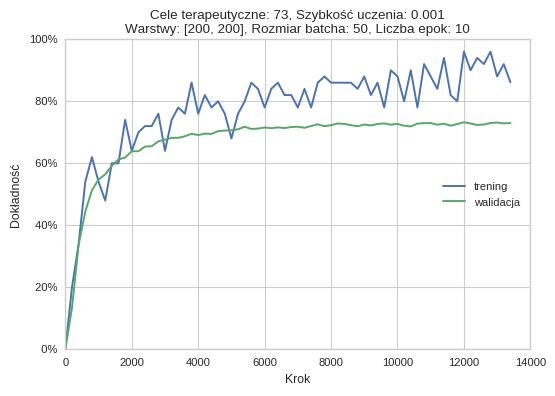

In [8]:
save_accuracy_plot(tr_rate, save=True, path="plots/")

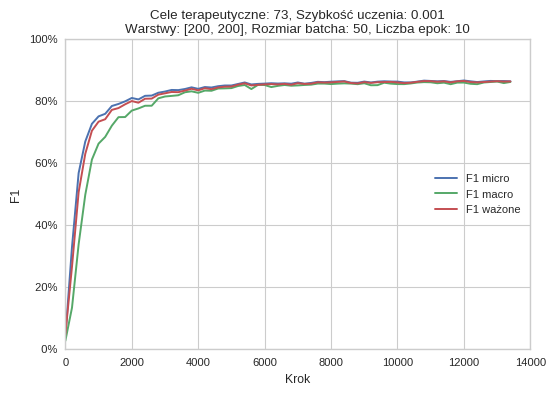

In [9]:
save_f1_plot(f1, save=True, path="plots/")

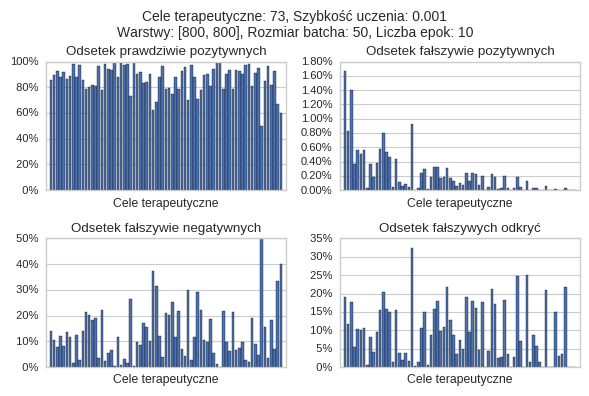

In [119]:
save_tf_fractions_plot(tf_frac, save=True, path="plots/")

In [67]:
save_res_to_file(rType,num_class,f_size,layers,learning_rate,batch_size,epochs,max(val_rate))

---

---

---

In [8]:
%%time
'''m_layers = [[100],[200],[500],
            [100,100],[200,200],[500,500],
            [100,100,100],[200,200,200],[500,500,500]]
'''
m_layers = [[200,200],[500,500],[800,800]]
m_lr_rate = [0.01,0.001,0.0001]
m_batch_size = [15,25,50]
#m_epochs = [10]
i = 0
for l in m_layers:
    layers = l
    for lrr in m_lr_rate:
        learning_rate = lrr
        if lrr == 0.0001:
            epochs = 20
        else:
            epochs = 10
        for bsize in m_batch_size:
            batch_size = bsize
            
            tf.reset_default_graph()
            tf.set_random_seed(15)
            random.seed(15)
            print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
            start = time.time()
            # Automatic network variables
            isize = len(val_mols[0])
            osize = num_class
            active_layers = setup_layers(layers, osize, isize)
            x = active_layers['x'] # first placeholder
            a = active_layers['out'][2] # output layer activations
            t = active_layers['out'][3] # placeholder for targets
            saver = tf.train.Saver(max_to_keep=12)
            # Objective
            '''Adam Optimizer'''
            cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(a, t))
            train = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
            # Prediction
            predict = tf.round(tf.nn.sigmoid(a))
            # Train the network
            tr_rate, val_rate, f1, tf_frac = train_network(train_set, batch_size, epochs, False, False)
            
            save_accuracy_plot(tr_rate, val_rate, layers, learning_rate, batch_size, epochs)
            save_f1_plot(f1, val_rate, layers, learning_rate, batch_size, epochs)
            save_tf_fractions_plot(tf_frac, val_rate, layers, learning_rate, batch_size, epochs)
            save_res_to_file(rType,num_class,f_size,layers,learning_rate,batch_size,epochs,max(val_rate))
            plt.close();
            total = len(m_layers) * len(m_lr_rate) * len(m_batch_size)
            full_time = timer(start,time.time())
            i += 1
            print(full_time, '{} out of {}'.format(i, total))

2017-08-28 11:35:52


/home/maks/anaconda3/envs/deep_learning/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/maks/anaconda3/envs/deep_learning/lib/python3.5/site-packages/ipykernel/__main__.py:83: RuntimeWarning: invalid value encountered in true_divide


00:02:42 1 out of 27
2017-08-28 11:38:34
00:01:46 2 out of 27
2017-08-28 11:40:20
00:01:01 3 out of 27
2017-08-28 11:41:21
00:02:42 4 out of 27
2017-08-28 11:44:03
00:01:47 5 out of 27
2017-08-28 11:45:51
00:01:02 6 out of 27
2017-08-28 11:46:53


/home/maks/anaconda3/envs/deep_learning/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


00:05:09 7 out of 27
2017-08-28 11:52:03
00:03:17 8 out of 27
2017-08-28 11:55:20
00:01:54 9 out of 27
2017-08-28 11:57:14
00:03:33 10 out of 27
2017-08-28 12:00:47
00:02:16 11 out of 27
2017-08-28 12:03:04
00:01:20 12 out of 27
2017-08-28 12:04:25
00:03:28 13 out of 27
2017-08-28 12:07:53
00:02:08 14 out of 27
2017-08-28 12:10:02
00:01:16 15 out of 27
2017-08-28 12:11:18
00:06:45 16 out of 27
2017-08-28 12:18:04
00:04:22 17 out of 27
2017-08-28 12:22:26
00:02:32 18 out of 27
2017-08-28 12:24:58
00:04:29 19 out of 27
2017-08-28 12:29:28
00:02:46 20 out of 27
2017-08-28 12:32:14
00:01:34 21 out of 27
2017-08-28 12:33:49
00:04:11 22 out of 27
2017-08-28 12:38:01
00:02:43 23 out of 27
2017-08-28 12:40:44
00:01:34 24 out of 27
2017-08-28 12:42:19
00:08:26 25 out of 27
2017-08-28 12:50:45
00:05:20 26 out of 27
2017-08-28 12:56:06
00:03:10 27 out of 27
CPU times: user 1h 9min 10s, sys: 27min 22s, total: 1h 36min 32s
Wall time: 1h 23min 23s


In [27]:
max(val_rate)

0.76609209257473476

---

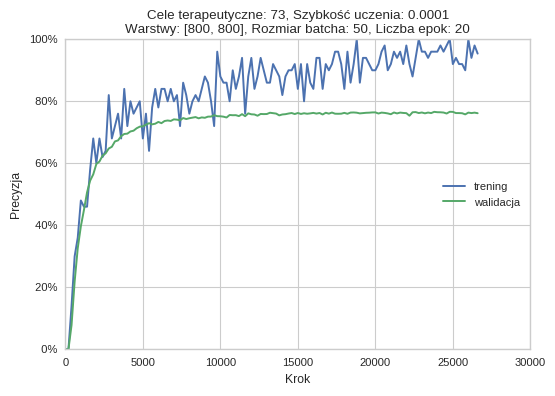

In [28]:
save_accuracy_plot(tr_rate, val_rate, layers, learning_rate, batch_size, epochs, False)

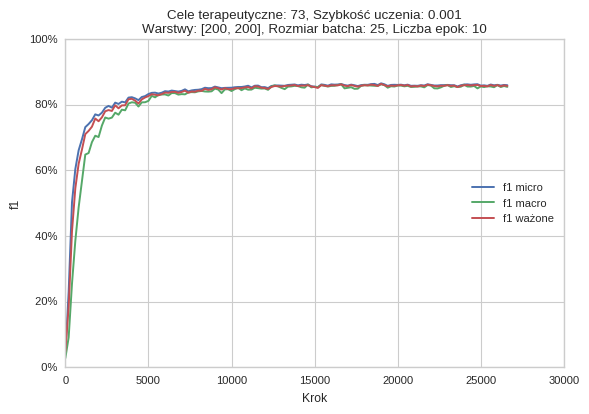

In [18]:
save_f1_plot(f1, val_rate, layers, learning_rate, batch_size, epochs)

In [105]:
save_tf_fractions_plot(tf_frac, val_rate, layers, learning_rate, batch_size, epochs)

TypeError: save_tf_fractions_plot() takes from 1 to 3 positional arguments but 6 were given

---

---

# Save results

In [21]:
with open('results.csv','w') as f:
    f.write('Type of Representation,Number of classes,Hidden Layers,Learning Rate,Batch Size,Number of Epochs, Max. Validation Rate\n')

In [22]:
def save_res_to_file(rType,num_class,f_size,layers,learning_rate,batch_size,epochs,max_val):
    with open('results.csv','a') as f:
        layers_str = str(layers).replace(',',';') #for .csv compatibility reasons
        s = "{},{},{},{},{},{},{},{:.4}\n".format(
            rType,num_class,f_size,layers_str,learning_rate,batch_size,epochs,max_val)
        f.write(s)

---

---

# Multiple runs

---

In [30]:
tr1, vr1 = tr_rate, val_rate

In [18]:
tr2, vr2 = tr_rate, val_rate

In [24]:
tr3, vr3 = tr_rate, val_rate

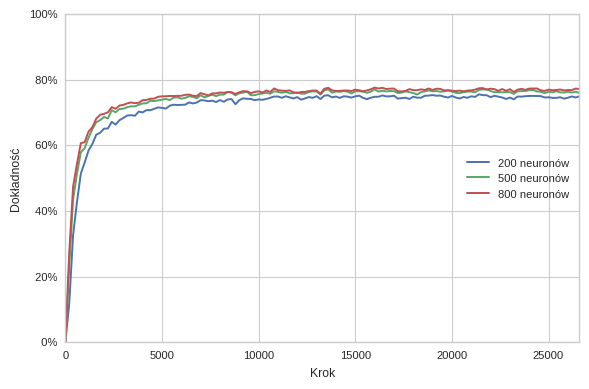

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)

x = [i*200 for i in range(len(tr_rate))]
ax.plot(x,vr1, label='200 neuronów')
ax.plot(x,vr2, label='500 neuronów')
ax.plot(x,vr3, label='800 neuronów')
ax.legend(loc=5)
ax.set_ylabel('Dokładność')
ax.set_xlabel('Krok')
plt.ylim([0,1])
plt.xlim([0,x[-1]])
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
plt.tight_layout()
plt.savefig('layers_diff.pdf')